In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#cluster = PBSCluster(cores=28, processes=18, walltime='00:40:00')
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(2)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.35:59326 Dashboard: http://10.148.1.35:8787/status,Cluster Workers: 2 Cores: 56 Memory: 240.00 GB


_________
# 1. Read dataset


In [5]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_bandpass = xr.open_zarr(out_dir_zarr+'U_bandpass_filter_rechunk.zarr')
ds_V_bandpass = xr.open_zarr(out_dir_zarr+'V_bandpass_filter_rechunk.zarr')
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_lowpass_filter_rechunk.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_lowpass_filter_rechunk.zarr')

ds_filter = xr.merge([ds_U_bandpass,ds_V_bandpass,ds_U_lowpass,ds_V_lowpass,grid])
print(ds_filter)

gridx = xgcm.Grid(ds_filter, coords={'X':{'center':'lon', 'left':'lon_g'},
                                     'Y':{'center':'lat', 'left':'lat_g'}}, periodic=['X', 'Y'])

<xarray.Dataset>
Dimensions:            (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * depth              (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
    dxC                (lat, lon_g) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    dyG                (lat, lon_g) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * lat                (lat) float64 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon_g              (lon_g) float64 -18.04 -18.02 -18.0 ... -14.4 -14.38
    rAw                (lat, lon_g) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * time               (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
    dxG                (lat_g, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    dyC                (lat_g, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * lat_g              (lat_g) float64 47.4 47.41 47.42 ... 49.96 49.97 49.98
  * lon           

In [6]:
u = gridx.interp(ds_filter.U_bandpass_filter, 'X')
v = gridx.interp(ds_filter.V_bandpass_filter, 'Y')
U = gridx.interp(ds_filter.U_low_filter, 'X')
V = gridx.interp(ds_filter.V_low_filter, 'Y')

du_dx = gridx.diff(ds_filter['U_bandpass_filter'], 'X')/gridx.interp(ds_filter.dxG, 'Y')
du_dy = gridx.interp(gridx.interp(gridx.diff(ds_filter['U_bandpass_filter'], 'Y')/gridx.interp(ds_filter.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(ds_filter['V_bandpass_filter'], 'X')/gridx.interp(ds_filter.dxC, 'Y'), 'X'), 'Y')
dv_dy = gridx.diff(ds_filter['V_bandpass_filter'], 'Y')/gridx.interp(ds_filter.dyG, 'X')

dU_dx = gridx.diff(ds_filter['U_low_filter'], 'X')/gridx.interp(ds_filter.dxG, 'Y')
dU_dy = gridx.interp(gridx.interp(gridx.diff(ds_filter['U_low_filter'], 'Y')/gridx.interp(ds_filter.dyC, 'X'), 'X'), 'Y')
dV_dx = gridx.interp(gridx.interp(gridx.diff(ds_filter['V_low_filter'], 'X')/gridx.interp(ds_filter.dxC, 'Y'), 'X'), 'Y')
dV_dy = gridx.diff(ds_filter['V_low_filter'], 'Y')/gridx.interp(ds_filter.dyG, 'X')

In [7]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [8]:
# works better with few worker but a lot of memories
VV = ['Pi_h_11']

for depth in depth_all:
    
    for vv in VV:
              
        Pi_h_11_whole = (U*U*du_dx + U*V*du_dy + U*V*dv_dx + V*V*dv_dy) + (u*U*du_dx + u*V*du_dy + v*U*dv_dx + v*V*dv_dy)  
        Pi_h_11 = Pi_h_11_whole.isel(depth=depth) 
        
        chunks = {'lat': 201, 'lon': 177, 'time':9415}
        Pi_h_11 = Pi_h_11.chunk(chunks)
        Pi_h_11 = np.real(Pi_h_11).rename('Pi_h_11')     
        Pi_h_11 = Pi_h_11.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        Pi_h_11.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [33]:
VV = ['Pi_h_14_1']

for depth in depth_all:
    
    for vv in VV:
              
        u_tot = U + u
        v_tot = V + v

        UV_term = (U*u + V*v)

        U_term_tmean = (UV_term*u_tot)
        V_term_tmean = (UV_term*v_tot)

        du_dx_14 = gridx.diff(U_term_tmean, 'X')/ds_filter.dxC
        du_dx_14_ij = gridx.interp(du_dx_14, 'X')

        dv_dy_14 = gridx.diff(V_term_tmean, 'Y')/ds_filter.dyC
        dv_dy_14_ij = gridx.interp(dv_dy_14, 'Y')


        Pi_h_14_1 = (du_dx_14_ij + dv_dy_14_ij).isel(depth=depth) 
        
        chunks = {'lat': 201, 'lon': 177, 'time':9415}
        Pi_h_14_1 = Pi_h_14_1.chunk(chunks)
        Pi_h_14_1 = np.real(Pi_h_14_1).rename('Pi_h_14_1')
        Pi_h_14_1 = Pi_h_14_1.to_dataset()

        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        Pi_h_14_1.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [11]:
VV = ['Pi_h_14_23']

for depth in depth_all:
    
    for vv in VV:
              
        Pi_h_14_whole = -(u*u*dU_dx + u*v*dU_dy + u*v*dV_dx + v*v*dV_dy)-(u*U*dU_dx + u*V*dU_dy + v*U*dV_dx + v*V*dV_dy) 
        Pi_h_14_23 = Pi_h_14_whole.isel(depth=depth) 
        
        chunks = {'lat': 201, 'lon': 177, 'time':9415}
        Pi_h_14_23 = Pi_h_14_23.chunk(chunks)
        Pi_h_14_23 = np.real(Pi_h_14_23).rename('Pi_h_14_23')     
        Pi_h_14_23 = Pi_h_14_23.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        Pi_h_14_23.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

____________________
# 2. Read results

In [5]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'Pi_h_11_d%02d.zarr'%(depth)) for depth in range(52)]

Pi_h_11 = xr.concat(D, dim='depth')
Pi_h_11 = Pi_h_11.Pi_h_11
Pi_h_11

<xarray.DataArray 'Pi_h_11' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [6]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'Pi_h_14_1_d%02d.zarr'%(depth)) for depth in range(52)]

Pi_h_14_1 = xr.concat(D, dim='depth')
Pi_h_14_1 = Pi_h_14_1.Pi_h_14_1
Pi_h_14_1

<xarray.DataArray 'Pi_h_14_1' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [7]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'Pi_h_14_23_d%02d.zarr'%(depth)) for depth in range(52)]

Pi_h_14_23 = xr.concat(D, dim='depth')
Pi_h_14_23 = Pi_h_14_23.Pi_h_14_23
Pi_h_14_23

<xarray.DataArray 'Pi_h_14_23' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

(1000.0, 0.0)

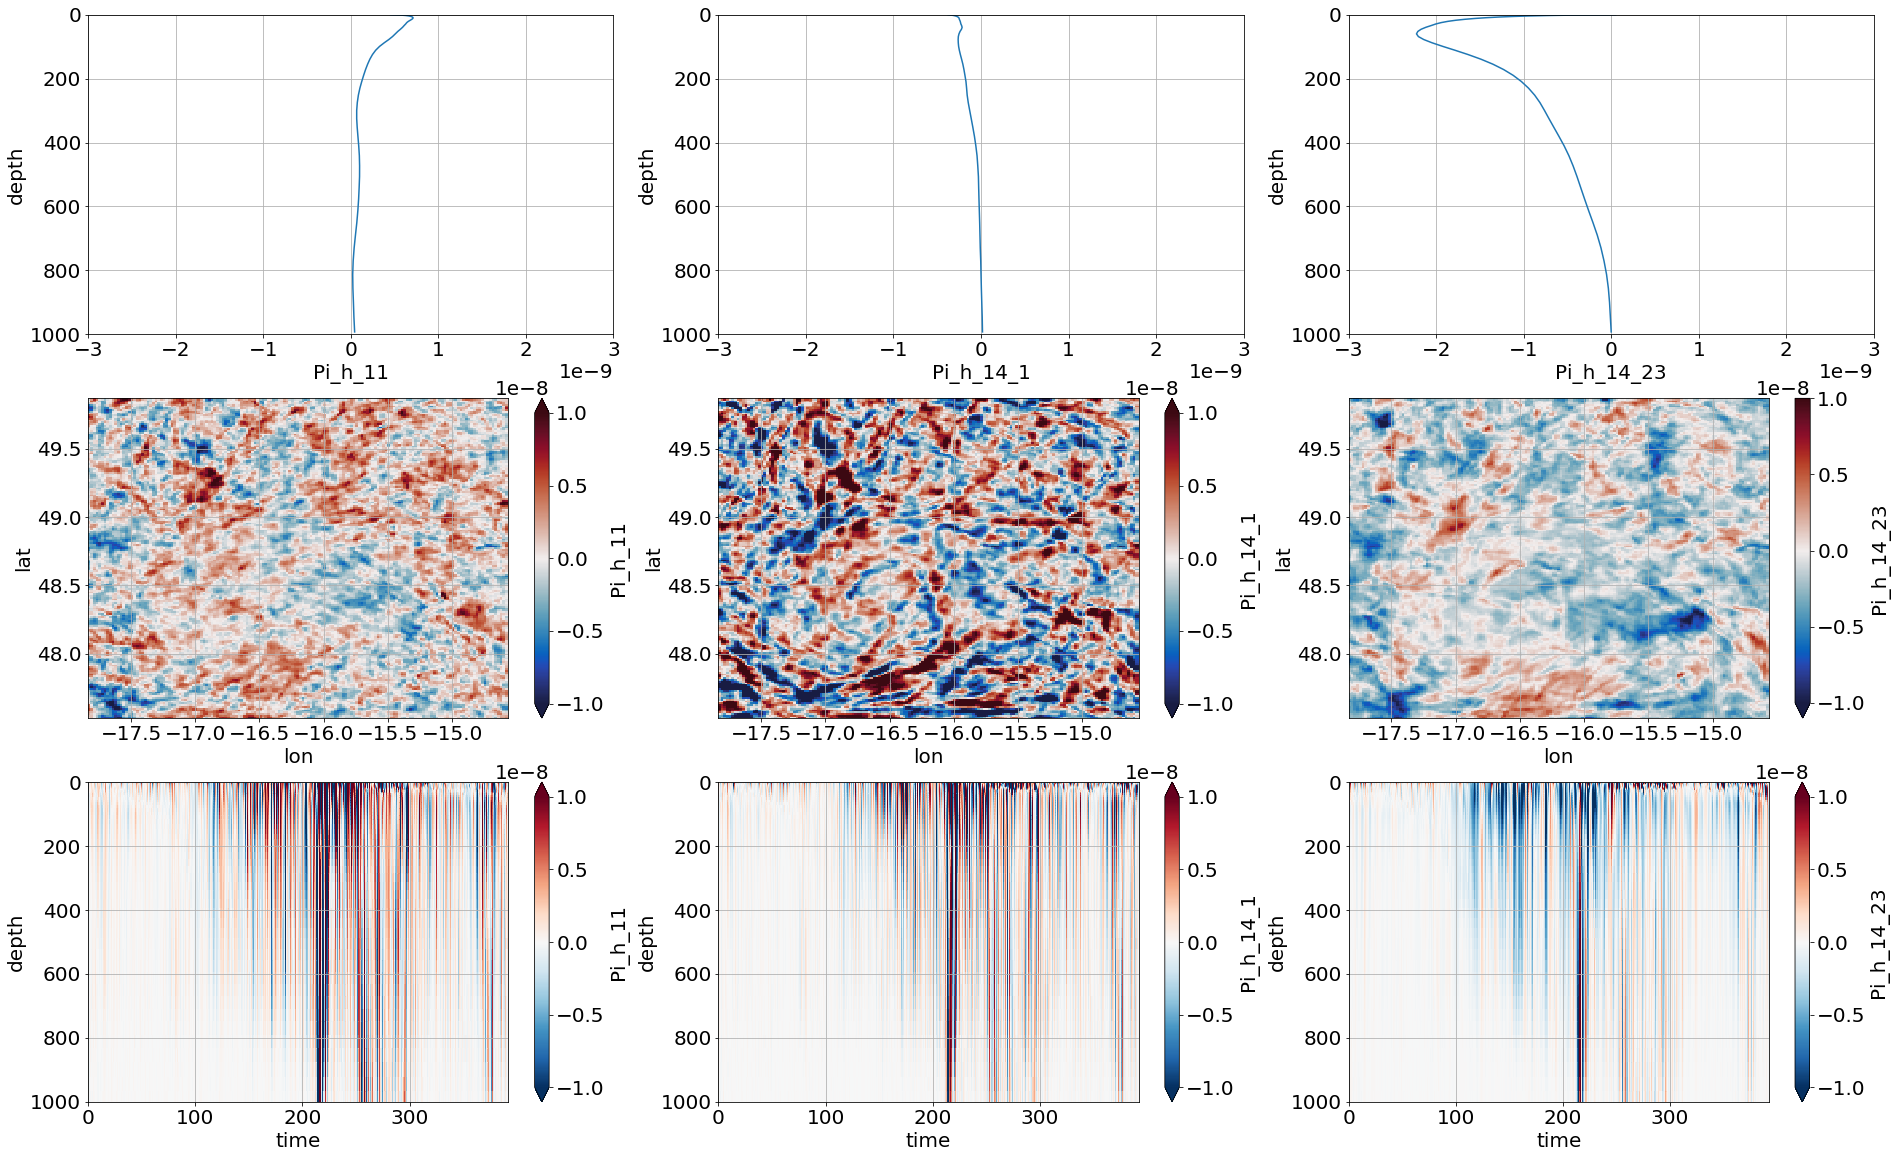

In [13]:
fig, ax = plt.subplots(figsize=(32,20))

ax = plt.subplot(331)
Pi_h_11.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat','time']).plot(y='depth',yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_xlim([-3e-9,3e-9])
ax = plt.subplot(332)
Pi_h_14_1.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat','time']).plot(y='depth',yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_xlim([-3e-9,3e-9])
ax = plt.subplot(333)
Pi_h_14_23.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat','time']).plot(y='depth',yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_xlim([-3e-9,3e-9])


ax = plt.subplot(334)
Pi_h_11.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['depth','time']).plot(x='lon',y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8)
ax.grid()
ax = plt.subplot(335)
Pi_h_14_1.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['depth','time']).plot(x='lon',y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8)
ax.grid()
ax = plt.subplot(336)
Pi_h_14_23.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['depth','time']).plot(x='lon',y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8)
ax.grid()

ax = plt.subplot(337)
Pi_h_11.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])
ax = plt.subplot(338)
Pi_h_14_1.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])
ax = plt.subplot(339)
Pi_h_14_23.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])

Text(0.5, 1.0, 'depth=21.125')

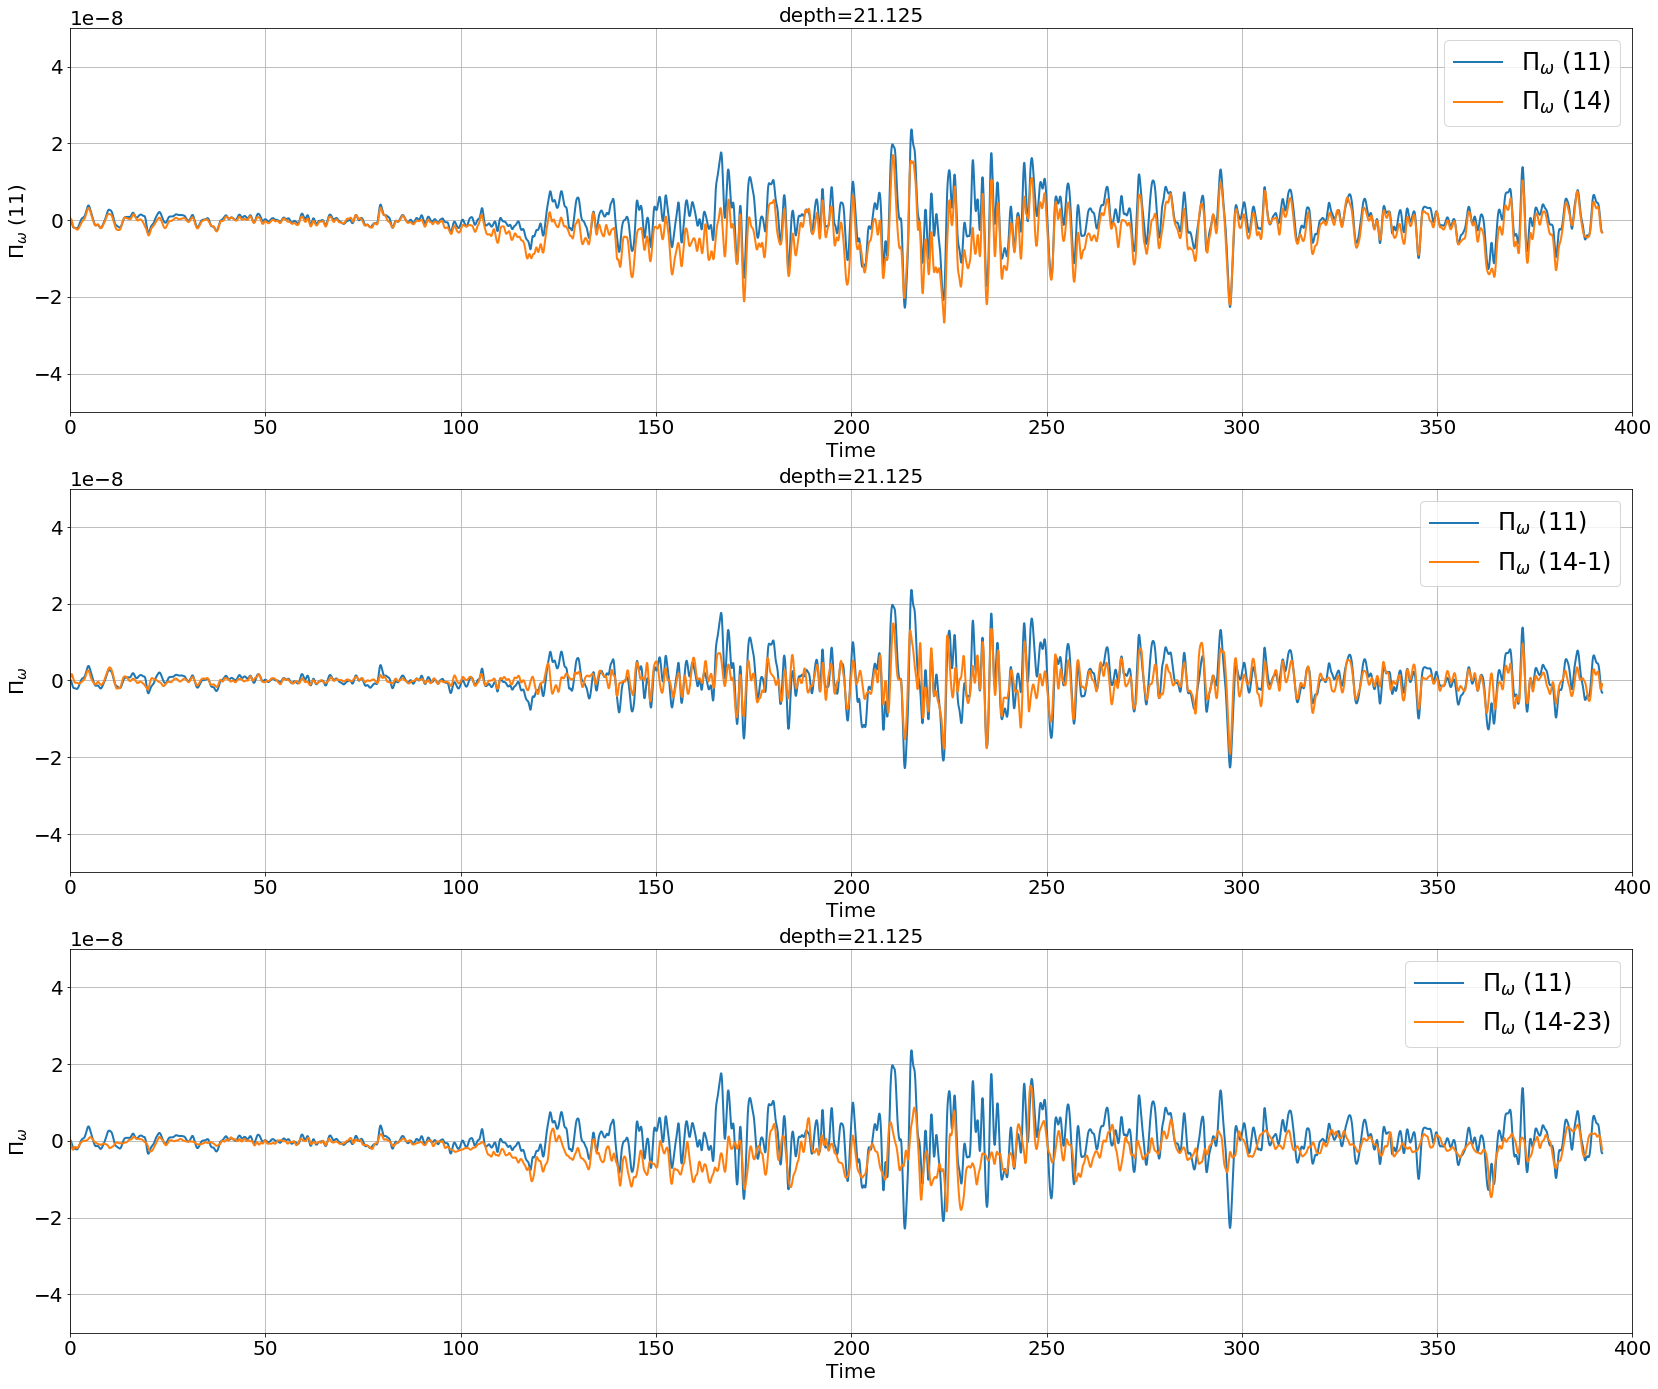

In [15]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,24))

ax = plt.subplot(311)
labels = ['$\Pi_{\omega}$ (11)', '$\Pi_{\omega}$ (14)']
Pi_h_11.isel(depth=20,lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon']).plot(label=labels[0], linewidth=2)
(Pi_h_14_1.isel(depth=20,lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon'])+Pi_h_14_23.isel(depth=20,lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon'])).plot(label=labels[1], linewidth=2)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})
ax.set_xlim([0,400])
ax.set_ylim([-5e-8,5e-8])
#ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('$\Pi_{\omega}$ (11) ',fontsize=font_size)
ax.set_xlabel('Time',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('depth=21.125',fontsize=font_size)

ax = plt.subplot(312)
labels = ['$\Pi_{\omega}$ (11)', '$\Pi_{\omega}$ (14-1)']

Pi_h_11.isel(depth=20,lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon']).plot(label=labels[0], linewidth=2)
Pi_h_14_1.isel(depth=20,lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon']).plot(label=labels[1], linewidth=2)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})
ax.set_xlim([0,400])
ax.set_ylim([-5e-8,5e-8])
#ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('$\Pi_{\omega}$ ',fontsize=font_size)
ax.set_xlabel('Time',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('depth=21.125',fontsize=font_size)

ax = plt.subplot(313)
labels = ['$\Pi_{\omega}$ (11)', '$\Pi_{\omega}$ (14-23)']

Pi_h_11.isel(depth=20,lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon']).plot(label=labels[0], linewidth=2)
Pi_h_14_23.isel(depth=20,lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon']).plot(label=labels[1], linewidth=2)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})
ax.set_xlim([0,400])
ax.set_ylim([-5e-8,5e-8])
#ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('$\Pi_{\omega}$ ',fontsize=font_size)
ax.set_xlabel('Time',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('depth=21.125',fontsize=font_size)

In [35]:
out_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

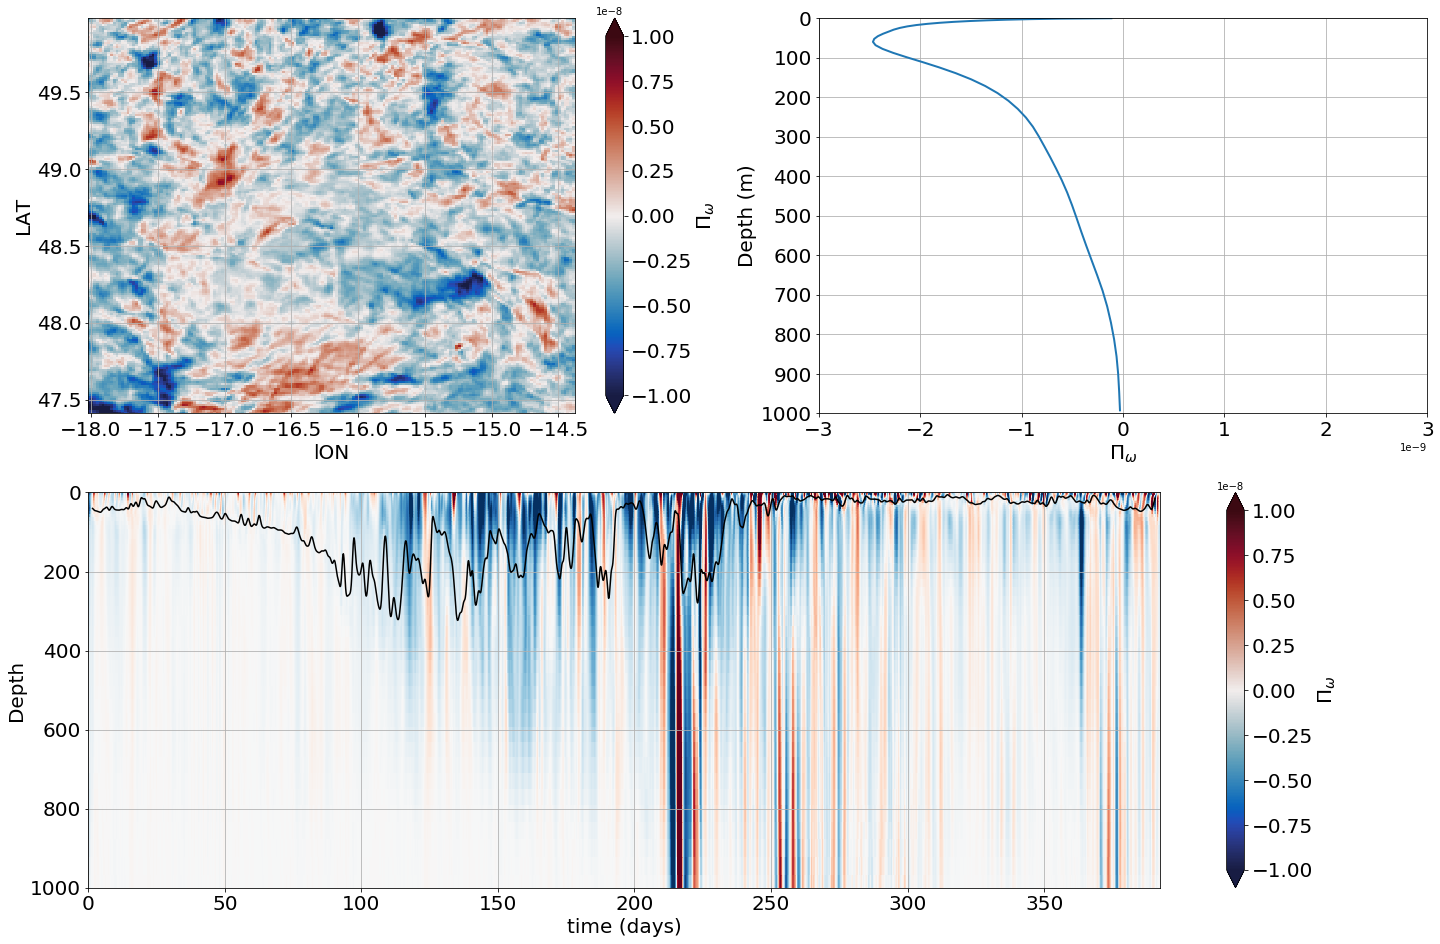

In [38]:
fig, ax = plt.subplots(figsize=(24,16))


ax = plt.subplot(221)
cax=Pi_h_14_23.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['depth','time']).plot(x='lon',y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('lON',fontsize=font_size)
ax.tick_params(labelsize=font_size)


ax = plt.subplot(222)
Pi_h_14_23.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat','time']).plot(y='depth',yincrease=False, linewidth=2)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_xlim([-3e-9,3e-9])
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])
ax.set_xticks([-3e-9, -2e-9, -1e-9, 0., 1e-9, 2e-9, 3e-9])
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$',fontsize=font_size)
ax.tick_params(labelsize=font_size)


ax = plt.subplot(2,2,(3,4))
cbar = Pi_h_14_23.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$', fontsize=font_size)
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_together.png')

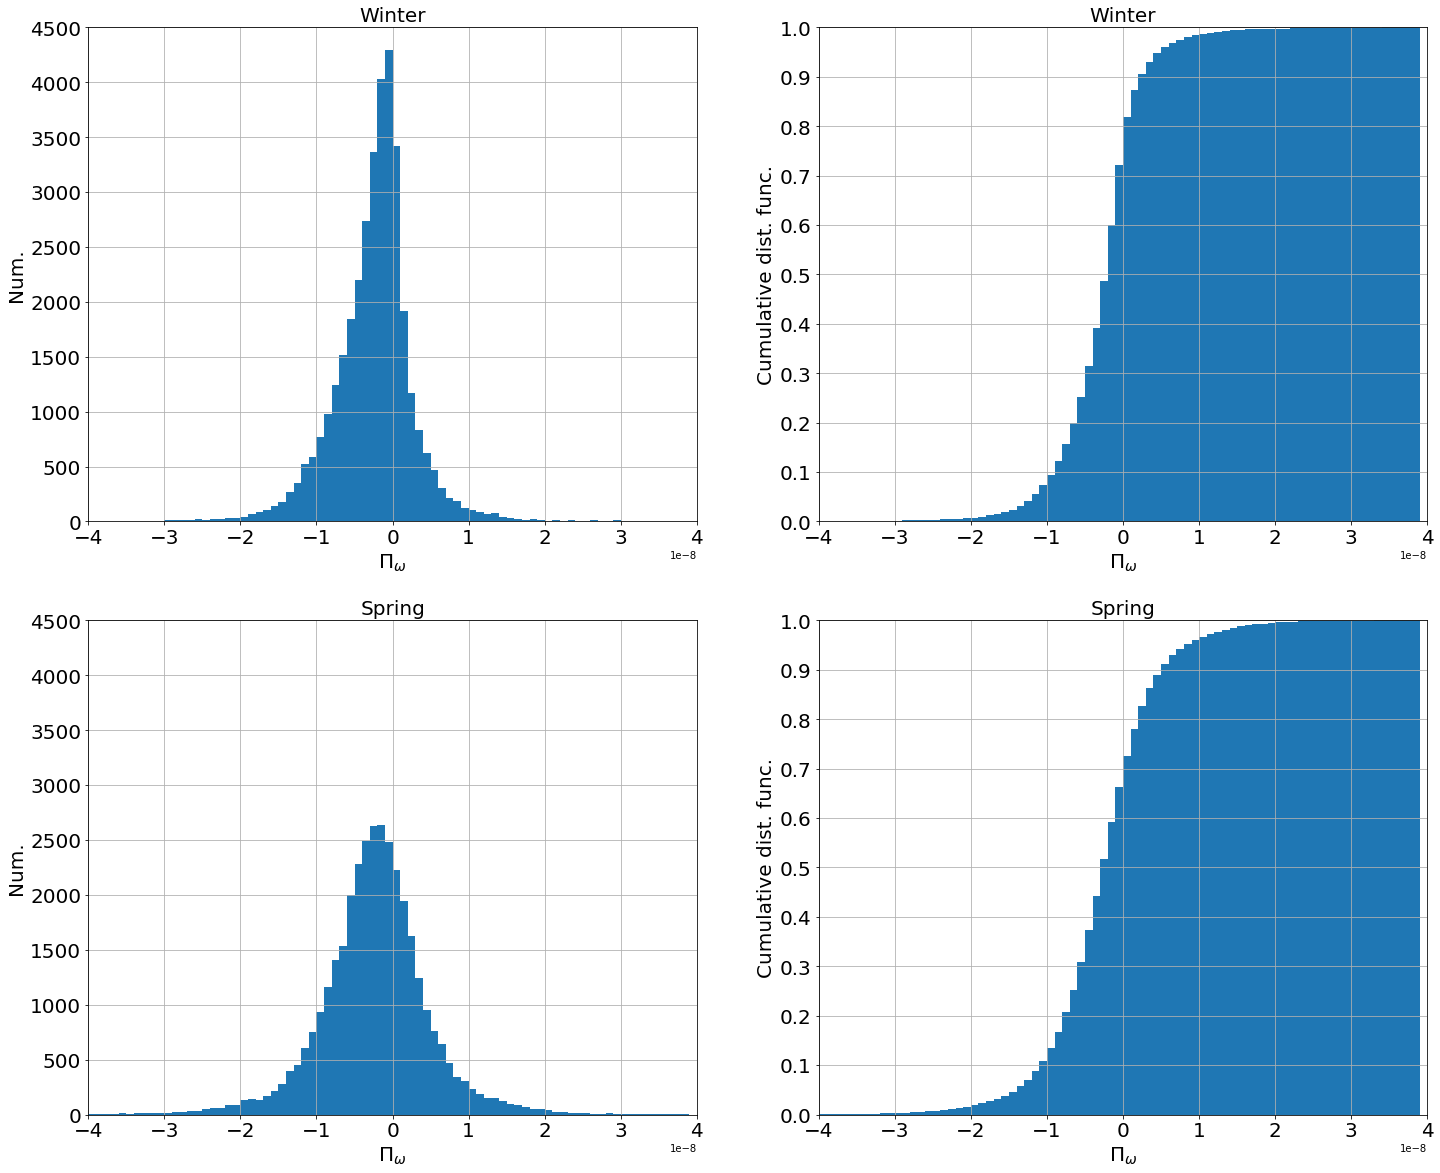

In [28]:
font_size = 20

fig, ax = plt.subplots(figsize=(24,20))

ax = plt.subplot(221)
Pi_h_14_23.isel(time=slice(2000,4000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9))
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,4500])
ax.set_ylabel('Num.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$',fontsize=font_size)
ax.set_title('Winter',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
Pi_h_14_23.isel(time=slice(2000,4000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9),density=True,cumulative=True)
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title('Winter',fontsize=font_size)
ax.set_ylabel('Cumulative dist. func.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(223)
Pi_h_14_23.isel(time=slice(4000,6000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9))
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,4500])
ax.set_ylabel('Num.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(224)
Pi_h_14_23.isel(time=slice(4000,6000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9),density=True,cumulative=True)
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_ylabel('Cumulative dist. func.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_histogram.png')

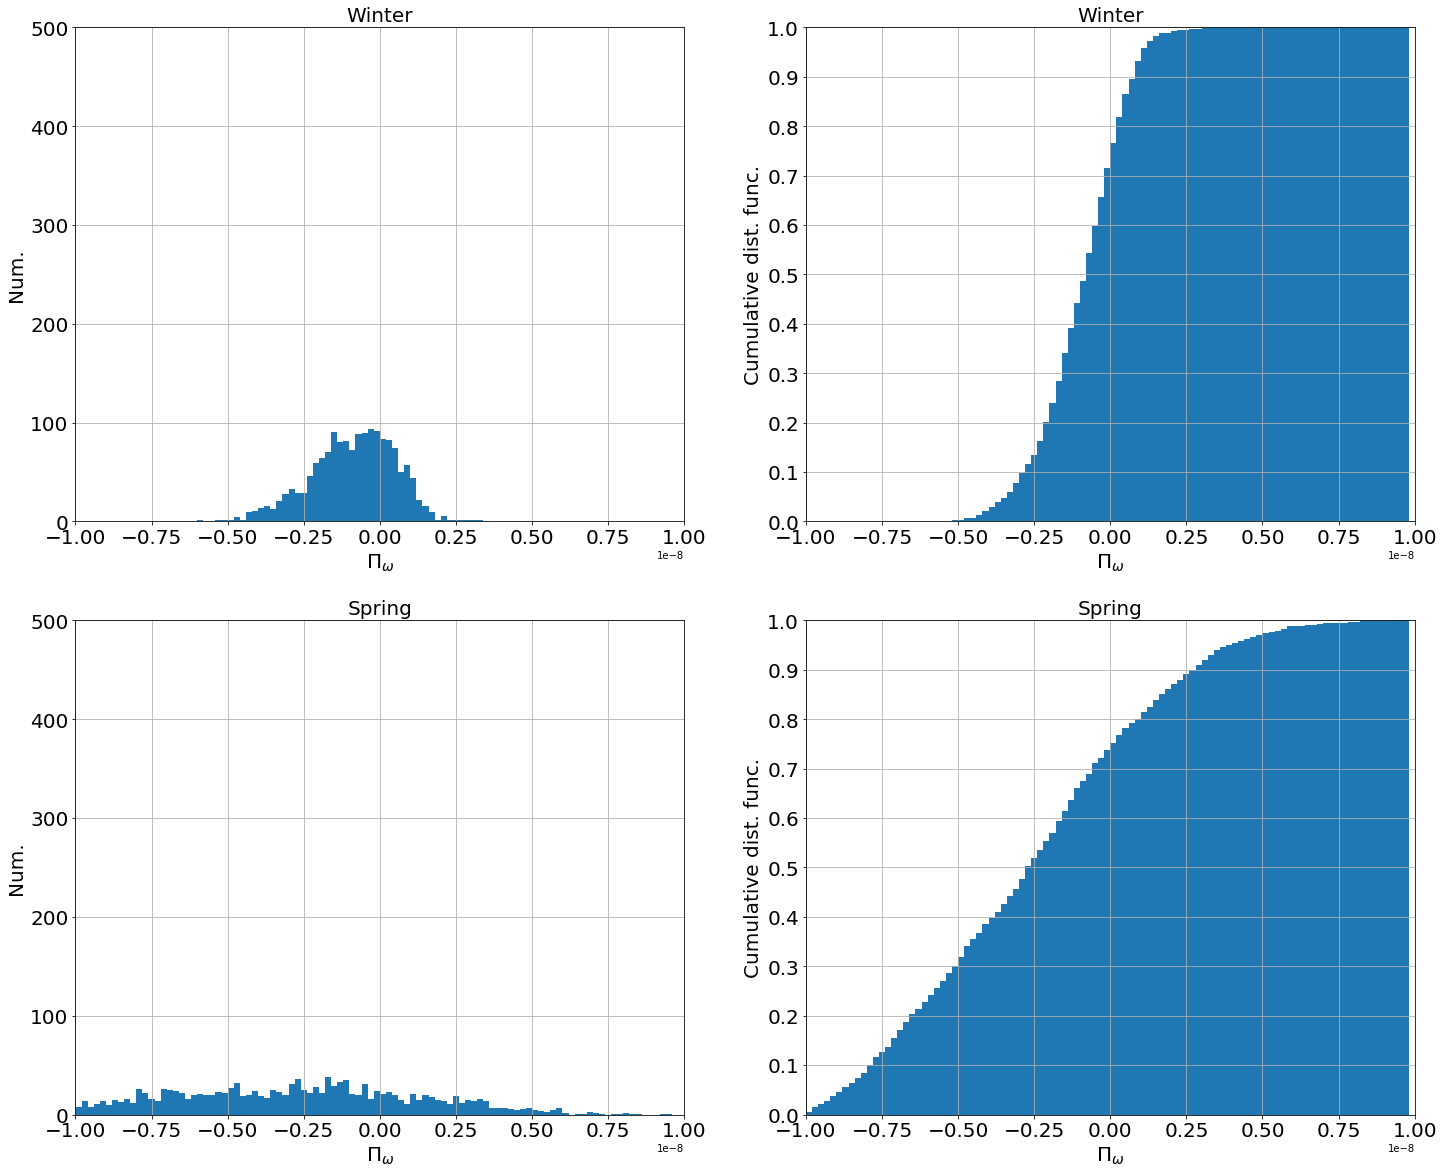

In [37]:
font_size = 20

fig, ax = plt.subplots(figsize=(24,20))

ax = plt.subplot(221)
Pi_h_14_23.isel(time=slice(2000,4000),depth=slice(15,40),lat=slice(80,120),lon=slice(70,110)).mean(['time','depth']).plot.hist(bins=np.arange(-1e-8,1e-8,2e-10))
ax.grid()
ax.set_xlim([-1e-8,1e-8])
ax.set_ylim([0.,500])
ax.set_ylabel('Num.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$',fontsize=font_size)
ax.set_title('Winter',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
Pi_h_14_23.isel(time=slice(2000,4000),depth=slice(15,40),lat=slice(80,120),lon=slice(70,110)).mean(['time','depth']).plot.hist(bins=np.arange(-1e-8,1e-8,2e-10),density=True,cumulative=True)
ax.grid()
ax.set_xlim([-1e-8,1e-8])
ax.set_ylim([0.,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title('Winter',fontsize=font_size)
ax.set_ylabel('Cumulative dist. func.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(223)
Pi_h_14_23.isel(time=slice(4000,6000),depth=slice(15,40),lat=slice(80,120),lon=slice(70,110)).mean(['time','depth']).plot.hist(bins=np.arange(-1e-8,1e-8,2e-10))
ax.grid()
ax.set_xlim([-1e-8,1e-8])
ax.set_ylim([0.,500])
ax.set_ylabel('Num.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(224)
Pi_h_14_23.isel(time=slice(4000,6000),depth=slice(15,40),lat=slice(80,120),lon=slice(70,110)).mean(['time','depth']).plot.hist(bins=np.arange(-1e-8,1e-8,2e-10),density=True,cumulative=True)
ax.grid()
ax.set_xlim([-1e-8,1e-8])
ax.set_ylim([0.,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_ylabel('Cumulative dist. func.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_histogram.png')

## a subdomain

(1000.0, 0.0)

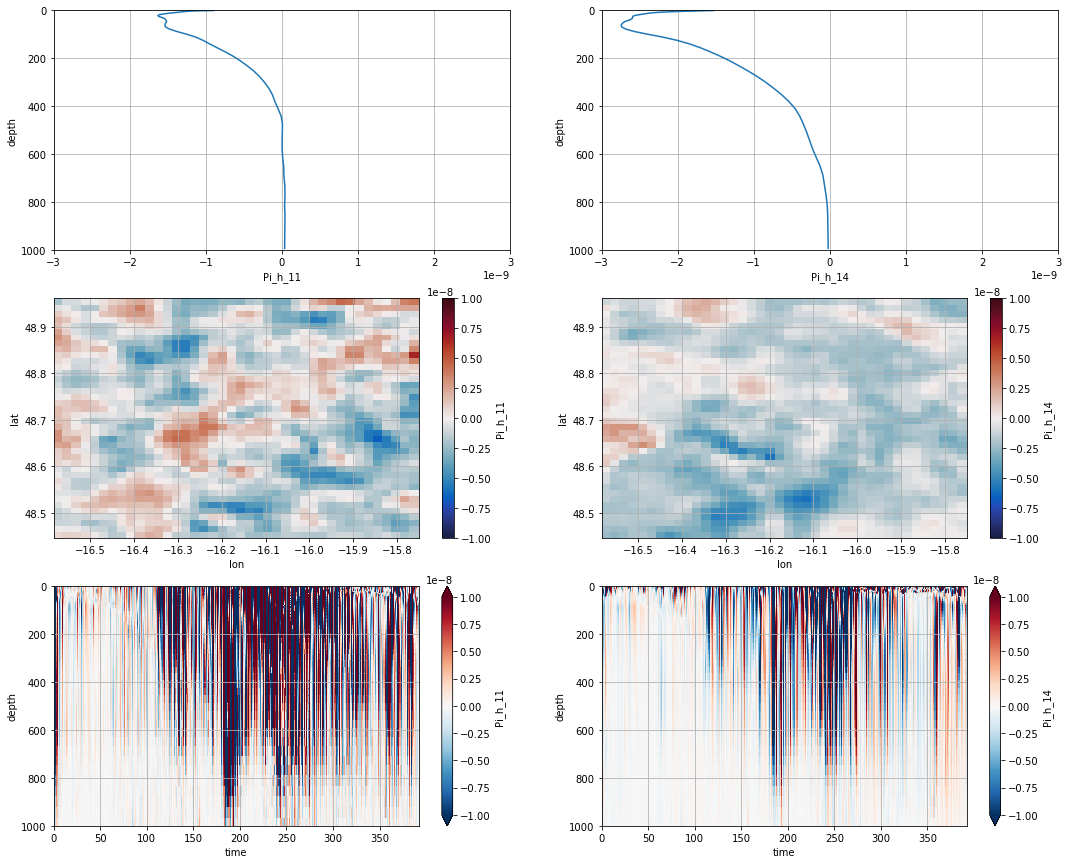

In [9]:
fig, ax = plt.subplots(figsize=(18,15))

ax = plt.subplot(321)
Pi_h_11.isel(lat=slice(80,120),lon=slice(70,110)).mean(['lon','lat','time']).plot(y='depth',yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_xlim([-3e-9,3e-9])
ax = plt.subplot(322)
Pi_h_14.isel(lat=slice(80,120),lon=slice(70,110)).mean(['lon','lat','time']).plot(y='depth',yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_xlim([-3e-9,3e-9])


ax = plt.subplot(323)
Pi_h_11.isel(lat=slice(80,120),lon=slice(70,110)).mean(['depth','time']).plot(x='lon',y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8)
ax.grid()
ax = plt.subplot(324)
Pi_h_14.isel(lat=slice(80,120),lon=slice(70,110)).mean(['depth','time']).plot(x='lon',y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8)
ax.grid()


ax = plt.subplot(325)
Pi_h_11.isel(lat=slice(80,120),lon=slice(70,110)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])
ax = plt.subplot(326)
Pi_h_14.isel(lat=slice(80,120),lon=slice(70,110)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])

## 3. Time tendency term

In [32]:
KE_submesoscale = 0.5*(u**2 + v**2)
KE_submesoscale

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<mul, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [33]:
KE_mesoscale = 0.5*(U**2 + V**2)
KE_mesoscale

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<mul, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [34]:
dKEs_dt = (KE_submesoscale.shift(time=-1) - KE_submesoscale.shift(time=1) )/2/3600
dKEm_dt = (KE_mesoscale.shift(time=-1) - KE_mesoscale.shift(time=1) )/2/3600

In [35]:
dKEs_dt

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

(1000.0, 0.0)

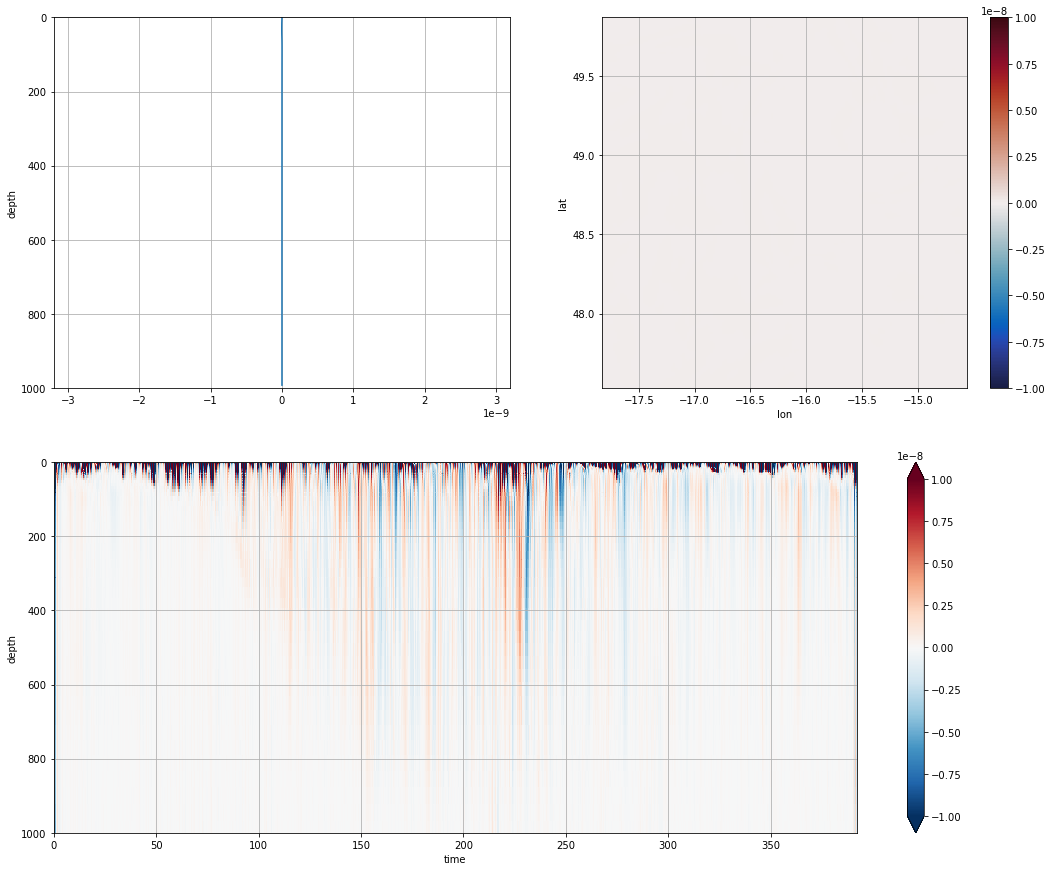

In [36]:
fig, ax = plt.subplots(figsize=(18,15))

ax = plt.subplot(221)
dKEs_dt.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat','time']).plot(y='depth',yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_xlim([-3.2e-9,3.2e-9])


ax = plt.subplot(222)
dKEs_dt.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['depth','time']).plot(x='lon',y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8)
ax.grid()

ax = plt.subplot(2,2,(3,4))
dKEs_dt.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])


(1000.0, 0.0)

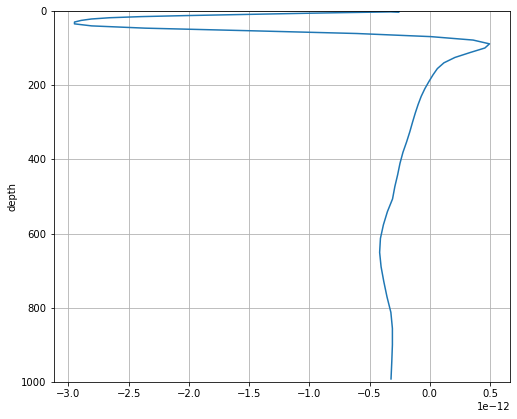

In [38]:
fig, ax = plt.subplots(figsize=(18,15))

ax = plt.subplot(221)
dKEs_dt.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat','time']).plot(y='depth',yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])

(1000.0, 0.0)

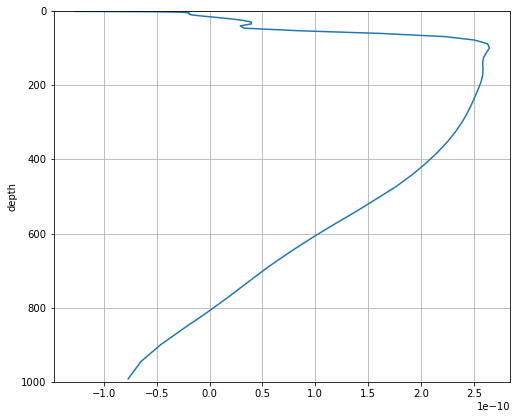

In [37]:
fig, ax = plt.subplots(figsize=(18,15))

ax = plt.subplot(221)
dKEm_dt.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat','time']).plot(y='depth',yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])
#ax.set_xlim([-3.2e-9,3.2e-9])

In [ ]:
fig, ax = plt.subplots(figsize=(18,15))

ax = plt.subplot(221)
dKEm_dt.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat','time']).plot(y='depth',yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])
ax.set_xlim([-3.2e-9,3.2e-9])


ax = plt.subplot(222)
dKEm_dt.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['depth','time']).plot(x='lon',y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8)
ax.grid()

ax = plt.subplot(2,2,(3,4))
dKEm_dt.isel(lat=slice(10,-10),lon=slice(10,-10)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)
ax.grid()
ax.set_ylim([1000., 0.])


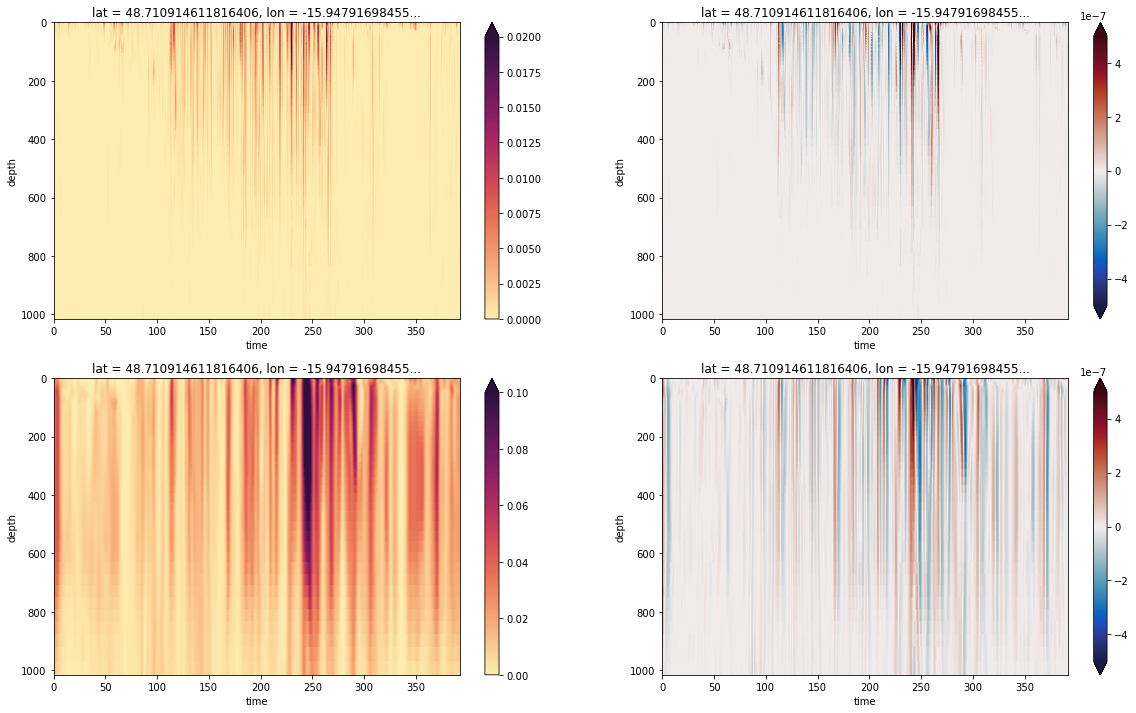

In [63]:
fig = plt.figure(figsize=(20,12))

plt.subplot(221)
KE_submesoscale.isel(lat=100,lon=100).plot(x='time', y='depth',cmap=cm.matter, vmin=0,vmax=0.02,yincrease=False)
plt.subplot(223)
KE_mesoscale.isel(lat=100,lon=100).plot(x='time', y='depth',cmap=cm.matter, vmin=0,vmax=0.1,yincrease=False)

plt.subplot(222)
dKEs_dt.isel(lat=100,lon=100).plot(x='time', y='depth',cmap=cm.balance,vmin=-5e-7,vmax=5e-7,yincrease=False)
plt.subplot(224)
dKEm_dt.isel(lat=100,lon=100).plot(x='time', y='depth',cmap=cm.balance,vmin=-5e-7,vmax=5e-7,yincrease=False)

In [40]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1